

# Caso: Predicción del valor generado a lo largo de la relación con el cliente a la empresa. (Customer Lifetime Value) con Python



In [3]:
# Paso 1: conectarnos a nuestro Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


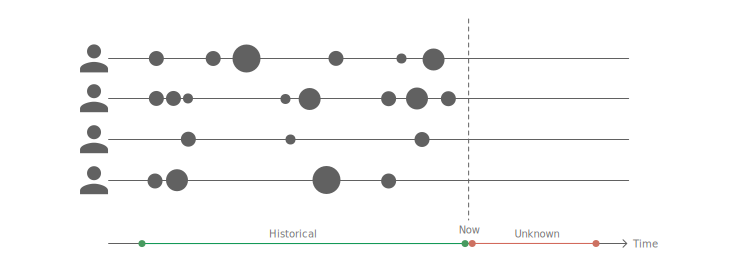

In [4]:
from IPython.display import SVG
SVG('/content/drive/MyDrive/Imágenes/clv-rfm.svg')
# Customer Life Time Value

There is a strong positive correlation between the recency, frequency, and amount of money spent on each purchase each customer makes and their CLV. Consequently, you leverage these features to in your ML model. For this lab, they are defined as:

* **Recency**: The time between the last purchase and today, represented by the distance between the rightmost circle and the vertical dotted line that's labeled "Now".
* **Frequency**: The time between purchases, represented by the distance between the circles on a single line.
* **Monetary**: The amount of money spent on each purchase, represented by the size of the circle. This amount could be the average order value or the quantity of products that the customer ordered.

### Dataset

In this lab, you use the publicly available [Online Retail data set](https://archive.ics.uci.edu/ml/datasets/online+retail) from the UCI Machine Learning Repository. This dataset contains 541,909 transnational customer transactions occuring between (YYYY-MM-DD) 2010-12-01 and 2011-12-09 for a UK-based and registered non-store retailer. The company primarily sells unique all-occasion gifts. Many of the company's customers are wholesalers.

**Citation**  
Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

In [5]:
# Paso 2: importar las librerías pertinentes
import pandas as pd

# Paso 3: ingestar nuestros datos
df = pd.read_excel('/content/drive/MyDrive/Datasets/Online Retail.xlsx')


In [6]:
# Verificació 1
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# Verificación 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Paso 4: Limpieza de datos
* Solo registros con customer ID
* Agregar las transacciones a nivel diario
* Solo obtener registros que tengan sentido (cantidades y valores monetarios positivos)
* Agregar las transacciones por cliente y calcular recency, frequency, monetary features así como la variable que se quiere predecir.

In [8]:
# prompt: drop all rows in df with customerid null

df = df.dropna(subset=['CustomerID'])


In [9]:
# prompt: drop all rows in df with quantity with negative values

df = df[df['Quantity'] > 0]


In [10]:
df.shape

(397924, 8)

In [11]:
from datetime import datetime

# Calculate the minimum date in the dataset
min_date = df['InvoiceDate'].min()

# Create a new column with the day number difference
df['DayNumber'] = (df['InvoiceDate'] - min_date).dt.days


In [12]:
# Sample 1 in 50 rows
df_sampled = df.sample(frac=0.05, random_state=42)  # Adjust random_state for reproducibility

df_sampled.shape


(19896, 9)

<Axes: xlabel='DayNumber', ylabel='Density'>

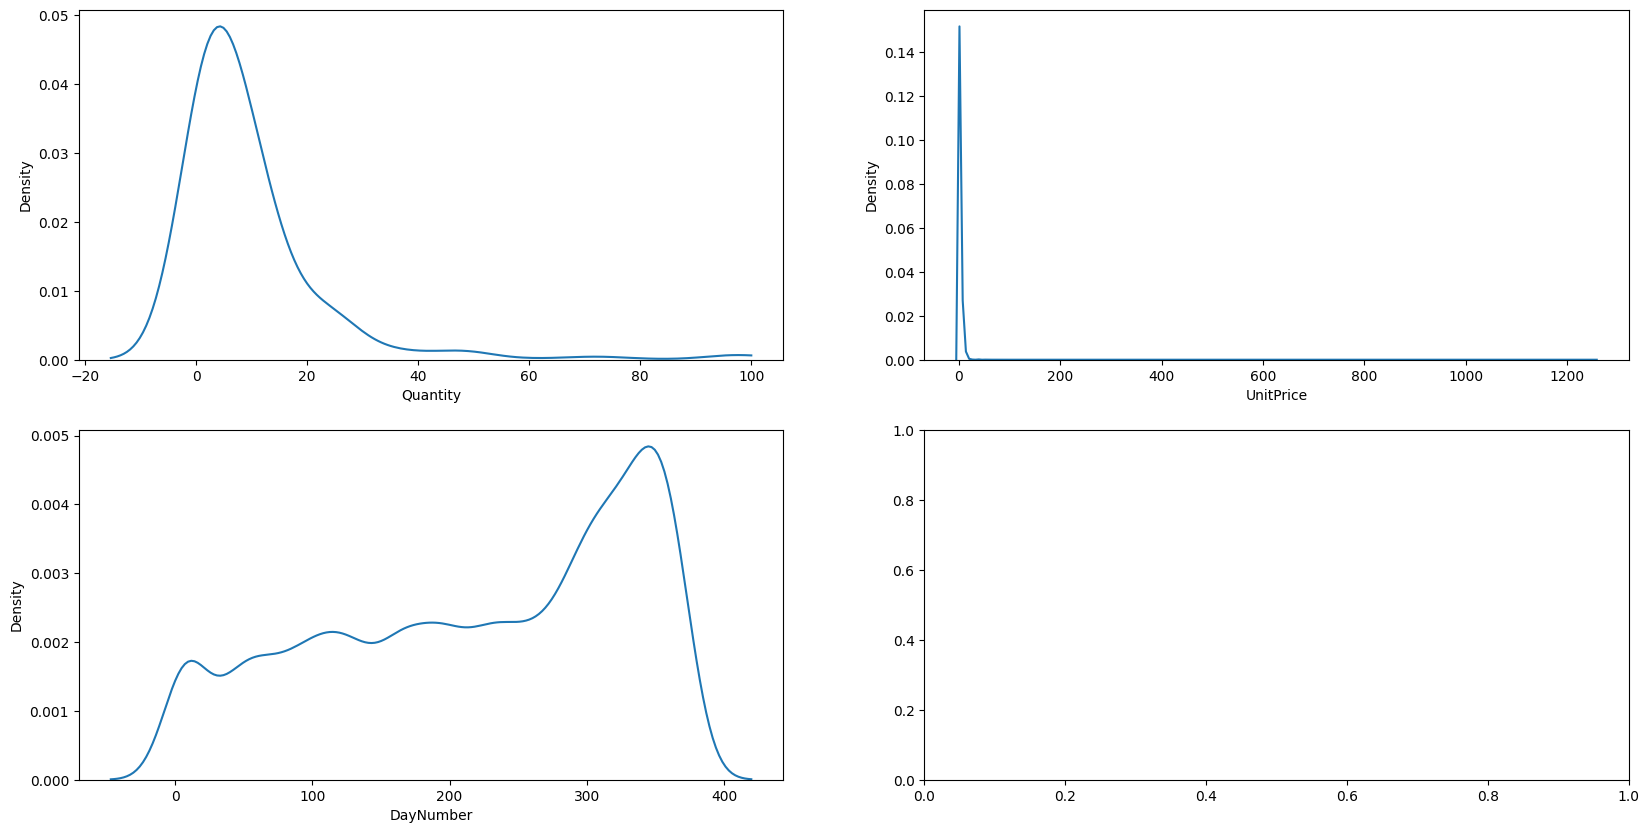

In [14]:
import seaborn as sns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# distplot not as easy to clip
# sns.distplot( df_original['Quantity'], ax=axs[0], label='quantity')
# sns.distplot(df_original['UnitPrice'], ax=axs[1], label='price')

sns.kdeplot(df_sampled['Quantity'], ax=axs[0, 0], label='quantity', clip=(-50, 100))
sns.kdeplot(df_sampled['UnitPrice'], ax=axs[0, 1], label='price', clip=(-50, 5000))
sns.kdeplot(df_sampled['DayNumber'], ax=axs[1, 0], label='days')

In [15]:
df_sampled['Quantity'].describe()

,Quantity
count,19896.000000
mean,12.623492
std,39.477140
min,1.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,1992.000000


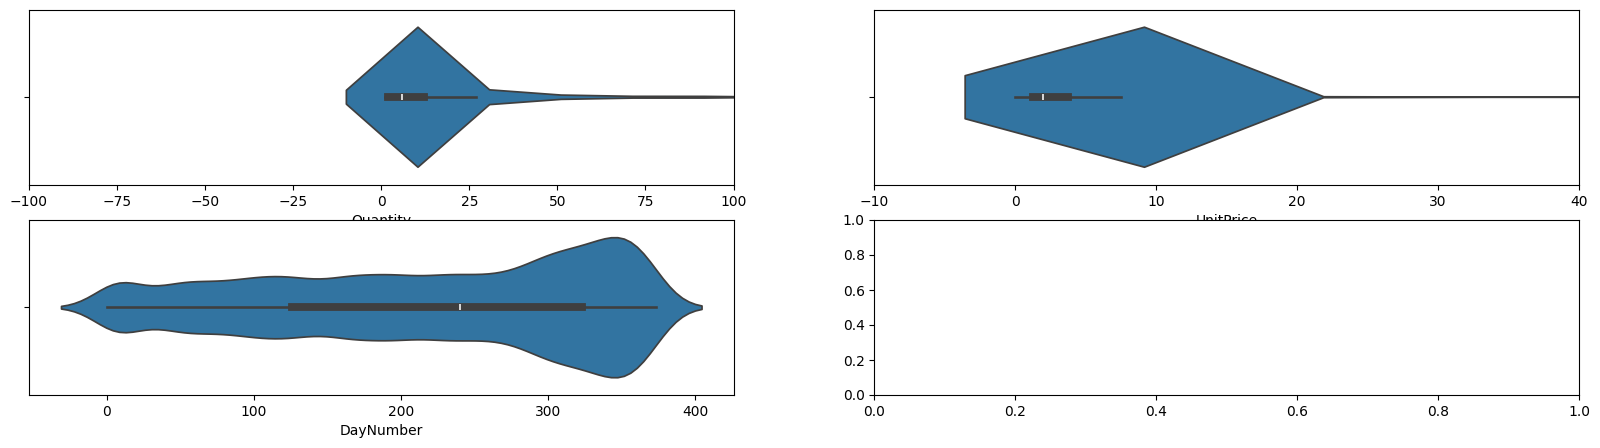

In [16]:
figv, axsv = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))

axq = sns.violinplot(x=df_sampled["Quantity"], ax=axsv[0, 0])
axq.set_xlim(-100, 100)

axp = sns.violinplot(x=df_sampled["UnitPrice"], ax=axsv[0, 1])
axp.set_xlim(-10, 40)

axd = sns.violinplot(x=df_sampled["DayNumber"], ax=axsv[1, 0])


In [17]:
# prompt: transform invoicedate to date format

df['InvoiceDate_2'] = pd.to_datetime(df['InvoiceDate'])
df[['InvoiceDate', 'InvoiceDate_2']]

,InvoiceDate,InvoiceDate_2
0,2010-12-01 08:26:00,2010-12-01 08:26:00
1,2010-12-01 08:26:00,2010-12-01 08:26:00
2,2010-12-01 08:26:00,2010-12-01 08:26:00
3,2010-12-01 08:26:00,2010-12-01 08:26:00
4,2010-12-01 08:26:00,2010-12-01 08:26:00
...,...,...
541904,2011-12-09 12:50:00,2011-12-09 12:50:00
541905,2011-12-09 12:50:00,2011-12-09 12:50:00
541906,2011-12-09 12:50:00,2011-12-09 12:50:00
541907,2011-12-09 12:50:00,2011-12-09 12:50:00


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      397924 non-null  object        
 1   StockCode      397924 non-null  object        
 2   Description    397924 non-null  object        
 3   Quantity       397924 non-null  int64         
 4   InvoiceDate    397924 non-null  datetime64[ns]
 5   UnitPrice      397924 non-null  float64       
 6   CustomerID     397924 non-null  float64       
 7   Country        397924 non-null  object        
 8   DayNumber      397924 non-null  int64         
 9   InvoiceDate_2  397924 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 33.4+ MB


In [19]:
# prompt: transform invoicedate to date format (yyyy-mm-dd)
df['InvoiceDate_3'] = pd.to_datetime(df['InvoiceDate']).dt.date
df[['InvoiceDate','InvoiceDate_2','InvoiceDate_3']]

,InvoiceDate,InvoiceDate_2,InvoiceDate_3
0,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01
1,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01
2,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01
3,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01
4,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01
...,...,...,...
541904,2011-12-09 12:50:00,2011-12-09 12:50:00,2011-12-09
541905,2011-12-09 12:50:00,2011-12-09 12:50:00,2011-12-09
541906,2011-12-09 12:50:00,2011-12-09 12:50:00,2011-12-09
541907,2011-12-09 12:50:00,2011-12-09 12:50:00,2011-12-09


In [20]:
# prompt: aggregate by invoicedate_3, customer_contry and customer id to find numer of purchases, order quantity and revenue (order * unit price)
# No Ejecutar
#df_agg = df.groupby(['InvoiceDate_3', 'Country', 'CustomerID'])\
#           .agg(number_of_purchases=('InvoiceNo', 'nunique'),
#                order_quantity=('Quantity', 'sum'),
#                revenue=('TotalPrice', 'sum')).reset_index()
#df_agg.head()


In [21]:
# prompt: create a new column TotalPrice = Quantity * UnitPrice

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [22]:
# Create a datetime object for the cutoff date
cutoff_date = datetime(2011, 9, 1)

# Create a new column based on the condition
df['DateCategory'] = df['InvoiceDate_2'].apply(lambda x: 'before' if x < cutoff_date else 'after')


In [23]:
# prompt: make a pivot table with data category for column and min and max of invoice date_3

pivot_table = df.pivot_table(values='InvoiceDate_3', index='DateCategory', aggfunc=['min', 'max'])
print(pivot_table)


                       min           max
             InvoiceDate_3 InvoiceDate_3
DateCategory                            
after           2011-09-01    2011-12-09
before          2010-12-01    2011-08-31


In [24]:
df_agg = df.groupby(['InvoiceDate_3', 'Country', 'CustomerID'])\
           .agg(number_of_purchases=('InvoiceNo', 'nunique'),
                order_quantity=('Quantity', 'sum'),
                revenue=('TotalPrice', 'sum')).reset_index()
df_agg.head()

,InvoiceDate_3,Country,CustomerID,number_of_purchases,order_quantity,revenue
0,2010-12-01,Australia,12431.0,1,107,358.25
1,2010-12-01,EIRE,14911.0,2,243,555.38
2,2010-12-01,France,12583.0,1,449,855.86
3,2010-12-01,Germany,12662.0,1,157,261.48
4,2010-12-01,Netherlands,12791.0,1,97,192.60


In [25]:
df_agg.shape

(16766, 6)

In [26]:
# prompt: filter all orders before o date 2011-09-01

from datetime import date

cutoff_date = date(2011, 9, 1)
df_filtered = df_agg[df_agg['InvoiceDate_3'] <= cutoff_date]

print(df_filtered.shape)

df_filtered.head()


(10437, 6)


,InvoiceDate_3,Country,CustomerID,number_of_purchases,order_quantity,revenue
0,2010-12-01,Australia,12431.0,1,107,358.25
1,2010-12-01,EIRE,14911.0,2,243,555.38
2,2010-12-01,France,12583.0,1,449,855.86
3,2010-12-01,Germany,12662.0,1,157,261.48
4,2010-12-01,Netherlands,12791.0,1,97,192.60


In [27]:
# prompt: aggregate df_filtered by customer id and county to find freatures count number of purchases, avg of order quantity, avg of revenue, difference between max order date and min order date (customer age) and difference cutoff date and max order date (last 2 in days)

# Aggregate the data by customer ID and country
customer_df = df_filtered.groupby(['CustomerID', 'Country']).agg(
    count_purchases=('number_of_purchases', 'count'),
    avg_order_quantity=('order_quantity', 'mean'),
    avg_revenue=('revenue', 'mean'),
    min_order_date=('InvoiceDate_3', 'min'),
    max_order_date=('InvoiceDate_3', 'max')
).reset_index()

# Ensure the date columns are in datetime format
customer_df['min_order_date'] = pd.to_datetime(customer_df['min_order_date'])
customer_df['max_order_date'] = pd.to_datetime(customer_df['max_order_date'])
customer_df['cutoff_date'] = pd.to_datetime(date(2011, 9, 1))
# Calculate customer age and recency
customer_df['customer_age'] = (customer_df['max_order_date'] - customer_df['min_order_date']).dt.days
customer_df['recency'] = (customer_df['cutoff_date'] - customer_df['max_order_date']).dt.days

# Drop the min and max order date columns
customer_df = customer_df.drop(['min_order_date', 'max_order_date'], axis=1)

customer_df.head()

,CustomerID,Country,count_purchases,avg_order_quantity,avg_revenue,cutoff_date,customer_age,recency
0,12346.0,United Kingdom,1,74215.0,77183.600000,2011-09-01,0,226
1,12347.0,Iceland,5,318.0,558.172000,2011-09-01,238,30
2,12348.0,Finland,3,708.0,495.746667,2011-09-01,110,149
3,12350.0,Norway,1,197.0,334.400000,2011-09-01,0,211
4,12352.0,Norway,4,63.5,390.452500,2011-09-01,34,163


In [28]:
customer_df.shape

(3330, 8)

In [29]:
# prompt: calculate from df_filtered total revenue by customerid

total_revenue_by_customer = df_filtered.groupby('CustomerID')['revenue'].sum()
print(total_revenue_by_customer.shape)
total_revenue_by_customer.head()

(3324,)


,revenue
CustomerID,
12346.0,77183.60
12347.0,2790.86
12348.0,1487.24
12350.0,334.40
12352.0,1561.81


In [30]:
# prompt: merge both total_revenue_by_customer (target) and customer_df by customerid (features)

customer_df_f = customer_df.merge(total_revenue_by_customer, on='CustomerID', how='inner')
customer_df_f.rename(columns={'revenue': 'total_revenue'}, inplace=True)
customer_df_f.head()


,CustomerID,Country,count_purchases,avg_order_quantity,avg_revenue,cutoff_date,customer_age,recency,total_revenue
0,12346.0,United Kingdom,1,74215.0,77183.600000,2011-09-01,0,226,77183.60
1,12347.0,Iceland,5,318.0,558.172000,2011-09-01,238,30,2790.86
2,12348.0,Finland,3,708.0,495.746667,2011-09-01,110,149,1487.24
3,12350.0,Norway,1,197.0,334.400000,2011-09-01,0,211,334.40
4,12352.0,Norway,4,63.5,390.452500,2011-09-01,34,163,1561.81


In [31]:
customer_df_f[['recency']].describe()

,recency
count,3330.000000
mean,92.521021
std,77.240666
min,0.000000
25%,27.000000
50%,73.000000
75%,146.750000
max,274.000000


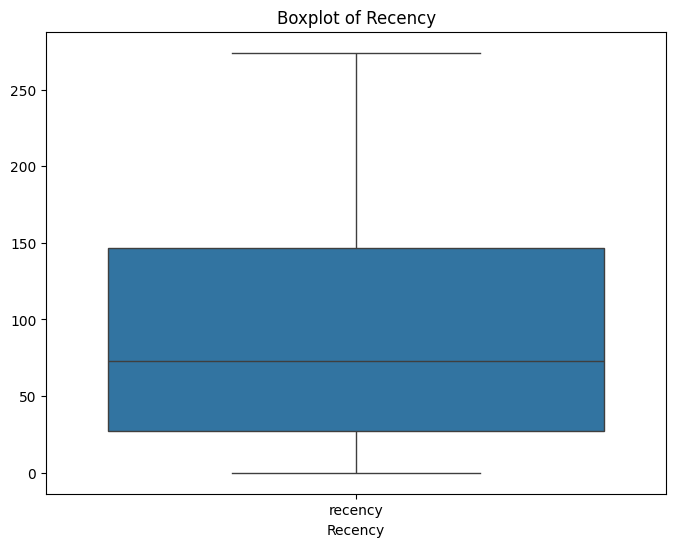

In [32]:
# prompt: turn this into a boxplot customer_df_f[['recency']].describe() and interpret results

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_df_f[['recency']])
plt.title('Boxplot of Recency')
plt.xlabel('Recency')
plt.show()

# Interpretation:
# - The median recency is around 50 days, meaning half of the customers made their last purchase within approximately 50 days of the cutoff date.
# - The interquartile range (IQR), represented by the box, spans from roughly 20 to 140 days. This indicates that 50% of the customers have a recency between 20 and 140 days.
# - The whiskers extend to the minimum and maximum recency values within 1.5 times the IQR. There are some outliers beyond the whiskers, indicating customers with unusually long periods since their last purchase.


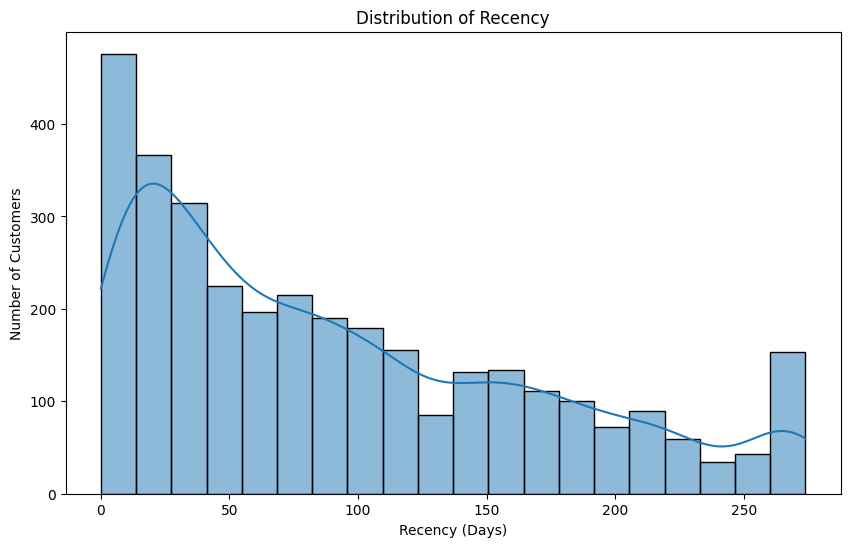

In [33]:
# prompt: now a histogram and interpret results

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_df_f['recency'], bins=20, kde=True)
plt.title('Distribution of Recency')
plt.xlabel('Recency (Days)')
plt.ylabel('Number of Customers')
plt.show()

# Interpretation:
# - The histogram shows a right-skewed distribution, indicating that a large portion of customers have made recent purchases (lower recency values).
# - The peak of the distribution is around 0-50 days, suggesting a high concentration of customers who have purchased within the last two months.
# - The tail of the distribution extends to higher recency values, representing customers who haven't made a purchase in a longer time.
# - The KDE (kernel density estimate) curve provides a smooth representation of the distribution, highlighting the concentration of recent purchases and the gradual decline in customer frequency as recency increases.


       count_purchases
count      3330.000000
mean          3.134234
std           4.504362
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          81.000000


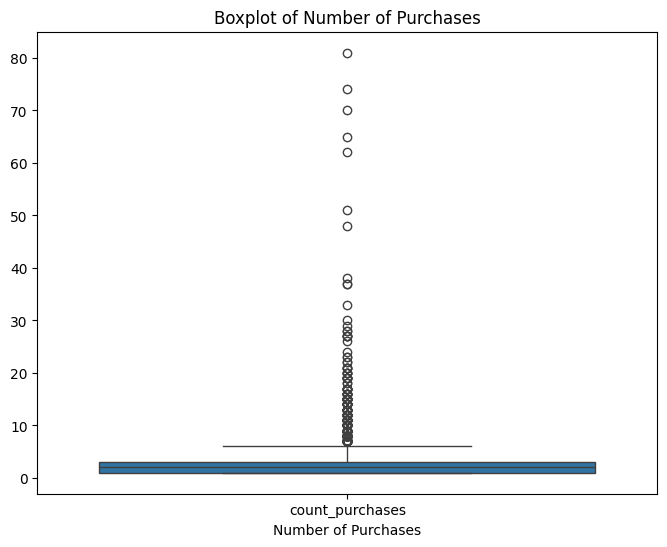

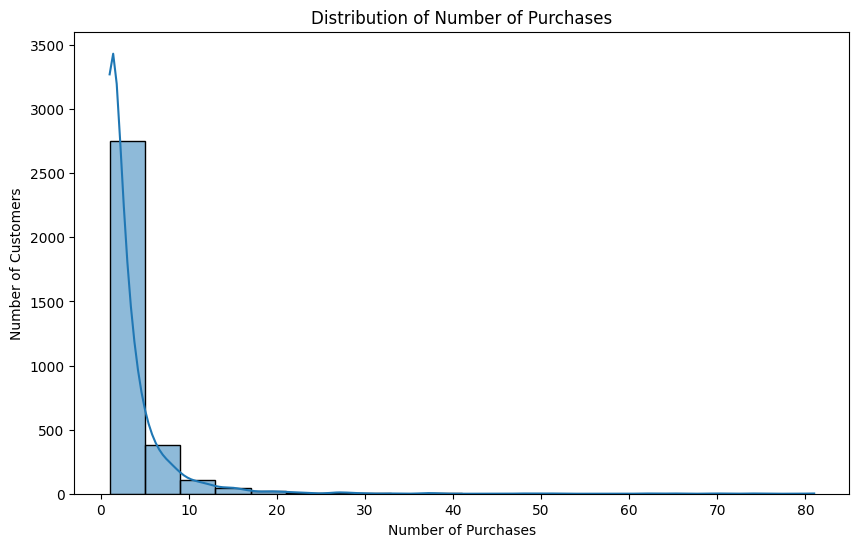

In [34]:
# prompt: make the same code (describe, boxplot and histogram) but for number of purchases

import matplotlib.pyplot as plt
print(customer_df_f[['count_purchases']].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_df_f[['count_purchases']])
plt.title('Boxplot of Number of Purchases')
plt.xlabel('Number of Purchases')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=customer_df_f['count_purchases'], bins=20, kde=True)
plt.title('Distribution of Number of Purchases')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.show()


        avg_revenue
count   3330.000000
mean     437.530695
std     1620.371969
min        2.900000
25%      175.739375
50%      296.150000
75%      439.014583
max    77183.600000


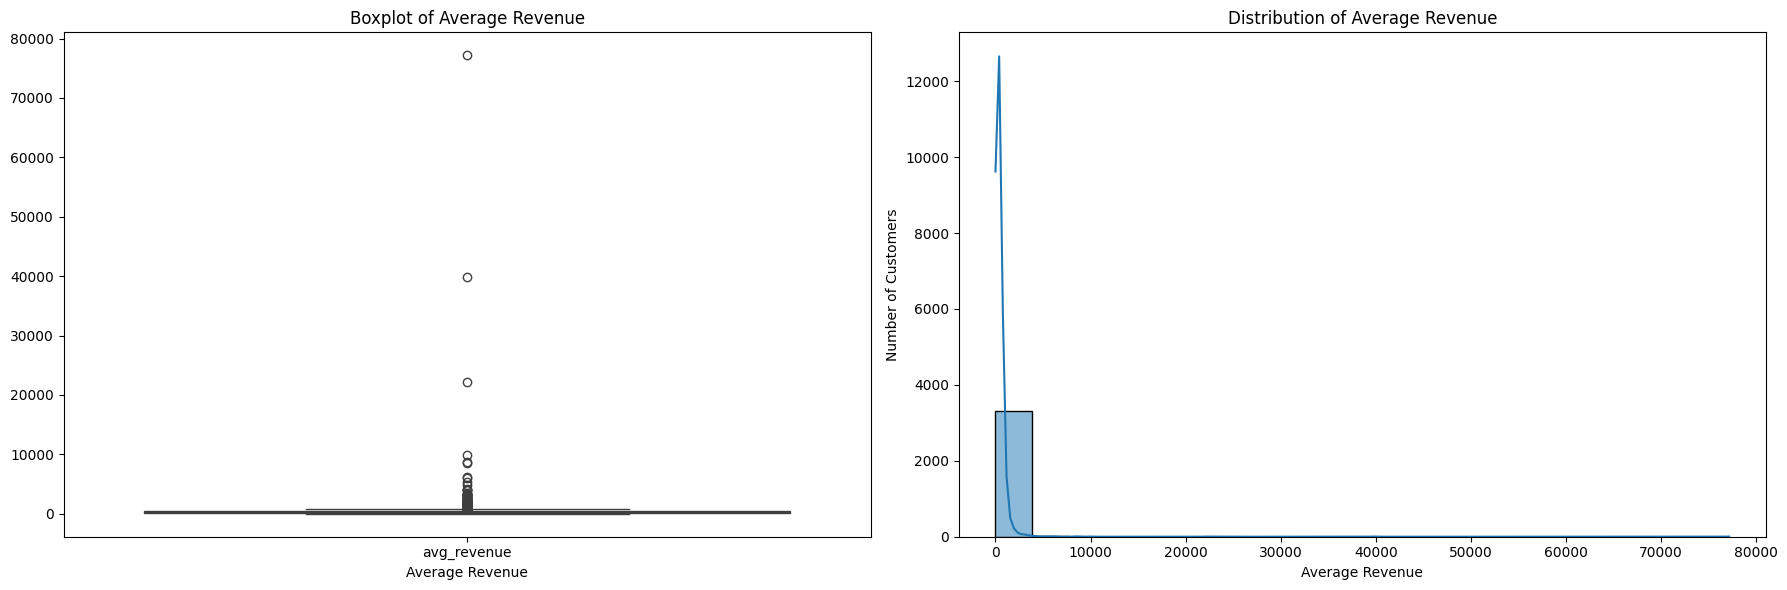

In [35]:
# prompt: make the same code (describe, boxplot and histogram) but for avg revenue (order the graph in one row)

import matplotlib.pyplot as plt
print(customer_df_f[['avg_revenue']].describe())

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=customer_df_f[['avg_revenue']], ax=axes[0])
axes[0].set_title('Boxplot of Average Revenue')
axes[0].set_xlabel('Average Revenue')

sns.histplot(data=customer_df_f['avg_revenue'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Average Revenue')
axes[1].set_xlabel('Average Revenue')
axes[1].set_ylabel('Number of Customers')

# Add a third plot (e.g., a scatter plot) if needed
# sns.scatterplot(x='avg_revenue', y='another_variable', data=customer_df_f, ax=axes[2])
# axes[2].set_title('Scatter Plot of Average Revenue vs. Another Variable')
# axes[2].set_xlabel('Average Revenue')
# axes[2].set_ylabel('Another Variable')

plt.tight_layout()
plt.show()


Establis a benchmark (elaborar bench mark) escoger varios modelos (lineal, n

In [36]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'DayNumber', 'InvoiceDate_2',
       'InvoiceDate_3', 'TotalPrice', 'DateCategory'],
      dtype='object')

In [60]:
# prompt: calculate share of rows with datacategro after and before

# Calculate the count of rows for each category
category_counts = df['DateCategory'].value_counts()

# Calculate the total number of rows
total_rows = len(df)

# Calculate the share of rows for each category
share_before = category_counts['before'] / total_rows
share_after = category_counts['after'] / total_rows

# Print the results
print("Share of rows with 'before' DateCategory:", share_before)
print("Share of rows with 'after' DateCategory:", share_after)
print(category_counts)

Share of rows with 'before' DateCategory: 0.569174013128135
Share of rows with 'after' DateCategory: 0.43082598687186496
DateCategory
before    226488
after     171436
Name: count, dtype: int64


In [61]:
df_benchmark = df[df.DateCategory == 'after']
df_benchmark.shape

(171436, 13)

In [62]:
df_benchmark.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayNumber,InvoiceDate_2,InvoiceDate_3,TotalPrice,DateCategory
320705,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,10.0,after
320706,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,30.0,after
320708,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,25.5,after
320709,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,30.0,after
320710,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,19.8,after


In [63]:
df_benchmark.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,DayNumber,InvoiceDate_2,TotalPrice
count,171436.000000,171436,171436.000000,171436.000000,171436.000000,171436,171436.000000
mean,12.296764,2011-10-26 13:41:49.463706880,3.019196,15301.928533,329.008528,2011-10-26 13:41:49.463706880,21.420048
min,1.000000,2011-09-01 08:25:00,0.000000,12347.000000,273.000000,2011-09-01 08:25:00,0.000000
25%,2.000000,2011-10-03 14:59:00,1.250000,14050.000000,306.000000,2011-10-03 14:59:00,4.150000
50%,4.000000,2011-10-30 12:18:00,1.790000,15152.000000,333.000000,2011-10-30 12:18:00,10.200000
75%,12.000000,2011-11-20 11:00:00,3.750000,16764.000000,354.000000,2011-11-20 11:00:00,18.720000
max,80995.000000,2011-12-09 12:50:00,4161.060000,18287.000000,373.000000,2011-12-09 12:50:00,168469.600000
std,201.717570,NaN,22.524304,1695.677473,27.865970,NaN,413.315223


In [64]:
# prompt: create a a flag for outliers in quantity column

# Calculate the IQR for the 'Quantity' column
Q1 = df_benchmark['Quantity'].quantile(0.25)
Q3 = df_benchmark['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a new column 'Quantity_Outlier' to flag outliers
df_benchmark['Quantity_Outlier'] = (df_benchmark['Quantity'] < lower_bound) | (df_benchmark['Quantity'] > upper_bound)
df_benchmark.head()

<ipython-input-64-5f1888ca2aa2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_benchmark['Quantity_Outlier'] = (df_benchmark['Quantity'] < lower_bound) | (df_benchmark['Quantity'] > upper_bound)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayNumber,InvoiceDate_2,InvoiceDate_3,TotalPrice,DateCategory,Quantity_Outlier
320705,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,10.0,after,False
320706,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,30.0,after,False
320708,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,25.5,after,False
320709,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,30.0,after,False
320710,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,19.8,after,False


In [65]:
# prompt: drop rows where outlier is true

df_benchmark = df_benchmark[df_benchmark['Quantity_Outlier'] == False]
df_benchmark.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayNumber,InvoiceDate_2,InvoiceDate_3,TotalPrice,DateCategory,Quantity_Outlier
320705,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,10.0,after,False
320706,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,30.0,after,False
320708,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,25.5,after,False
320709,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,30.0,after,False
320710,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,19.8,after,False


In [66]:
df_benchmark.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,DayNumber,InvoiceDate_2,TotalPrice
count,161247.000000,161247,161247.000000,161247.000000,161247.000000,161247,161247.000000
mean,6.826533,2011-10-26 17:27:51.025693440,3.118392,15310.790235,329.164580,2011-10-26 17:27:51.025693440,13.696097
min,1.000000,2011-09-01 08:25:00,0.000000,12347.000000,273.000000,2011-09-01 08:25:00,0.000000
25%,2.000000,2011-10-04 08:56:00,1.250000,14056.000000,307.000000,2011-10-04 08:56:00,3.750000
50%,4.000000,2011-10-30 12:53:00,1.950000,15159.000000,333.000000,2011-10-30 12:53:00,9.960000
75%,12.000000,2011-11-20 11:28:00,3.750000,16767.000000,354.000000,2011-11-20 11:28:00,17.400000
max,27.000000,2011-12-09 12:50:00,4161.060000,18287.000000,373.000000,2011-12-09 12:50:00,4161.060000
std,6.629061,NaN,23.218628,1692.443286,27.807744,NaN,27.866281


In [67]:
df_benchmark.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayNumber,InvoiceDate_2,InvoiceDate_3,TotalPrice,DateCategory,Quantity_Outlier
320705,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,10.0,after,False
320706,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,273,2011-09-01 08:25:00,2011-09-01,30.0,after,False
320708,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,25.5,after,False
320709,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,30.0,after,False
320710,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,274,2011-09-01 09:15:00,2011-09-01,19.8,after,False


In [68]:
# Calculating Y (dependent variable)
y_benchmark = df_benchmark.groupby('CustomerID')['TotalPrice'].sum().reset_index()
y_benchmark.head()

,CustomerID,TotalPrice
0,12347.0,1303.62
1,12348.0,40.00
2,12349.0,1667.55
3,12352.0,944.23
4,12356.0,58.35


In [70]:
# prompt: create x_benchmark group by customerid, order date calculate order quantity

x_benchmark = df_benchmark.groupby(['CustomerID', 'InvoiceDate_3'])[['Quantity','TotalPrice']].sum().reset_index()
x_benchmark.head()


,CustomerID,InvoiceDate_3,Quantity,TotalPrice
0,12347.0,2011-10-31,556,1078.80
1,12347.0,2011-12-07,192,224.82
2,12348.0,2011-09-25,1,40.00
3,12349.0,2011-11-21,559,1667.55
4,12352.0,2011-09-20,103,366.25


In [72]:
# prompt: calculate average of totalprice as avg_basket_value and count of quantity as cnt_orders

x_benchmark_agg = x_benchmark.groupby('CustomerID').agg(avg_basket_value=('TotalPrice', 'mean'),
                                                        cnt_orders=('Quantity', 'count')).reset_index()
x_benchmark_agg.head()


,CustomerID,avg_basket_value,cnt_orders
0,12347.0,651.810000,2
1,12348.0,40.000000,1
2,12349.0,1667.550000,1
3,12352.0,314.743333,3
4,12356.0,58.350000,1


In [75]:
# prompt: join x_benchmark_agg with y_benchmark to find   SELECT
#     tf.customer_id,
#     avg_basket_value * ( cnt_orders * (1 + 100/273) ) AS predicted_monetary,
#     ROUND(tt.target_monetary, 2) AS target_monetary

joined_df = x_benchmark_agg.merge(y_benchmark, on='CustomerID', how='inner')
joined_df['predicted_monetary'] = joined_df['avg_basket_value'] * (joined_df['cnt_orders'] * (1 + 100/273))
joined_df['target_monetary'] = joined_df['TotalPrice'].round(2)
joined_df = joined_df[['CustomerID', 'predicted_monetary', 'target_monetary']]
joined_df.head()


,CustomerID,predicted_monetary,target_monetary
0,12347.0,1781.136484,1303.62
1,12348.0,54.652015,40.00
2,12349.0,2278.374176,1667.55
3,12352.0,1290.101795,944.23
4,12356.0,79.723626,58.35


RMSE: 726.88


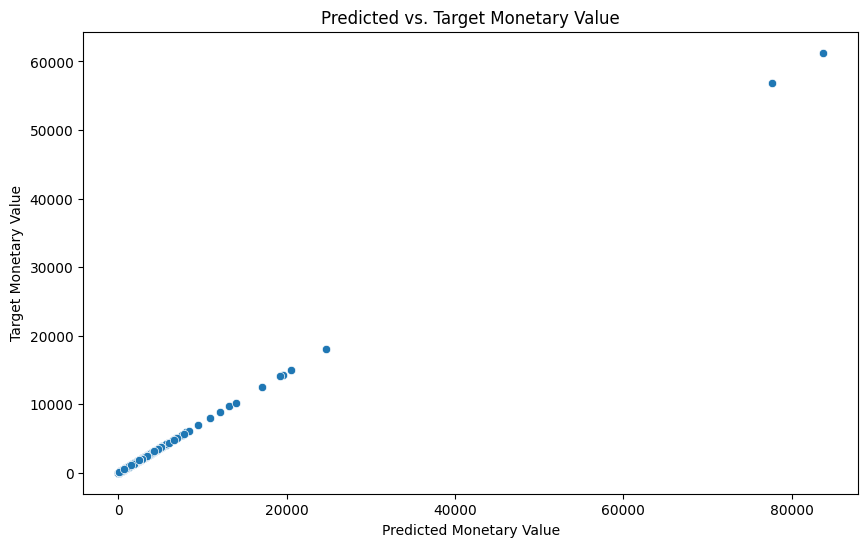

In [76]:
# prompt: calculate   ROUND(SQRT( SUM(POW(predicted_monetary - target_monetary, 2)) / COUNT(1) ), 2) as rmse
# and make a graph of predicted against target

import matplotlib.pyplot as plt
import numpy as np

# Calculate RMSE
rmse = np.round(np.sqrt(((joined_df['predicted_monetary'] - joined_df['target_monetary']) ** 2).sum() / joined_df.shape[0]), 2)
print("RMSE:", rmse)

# Plot predicted against target
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_monetary', y='target_monetary', data=joined_df)
plt.title('Predicted vs. Target Monetary Value')
plt.xlabel('Predicted Monetary Value')
plt.ylabel('Target Monetary Value')
plt.show()


RMSE: 726.88


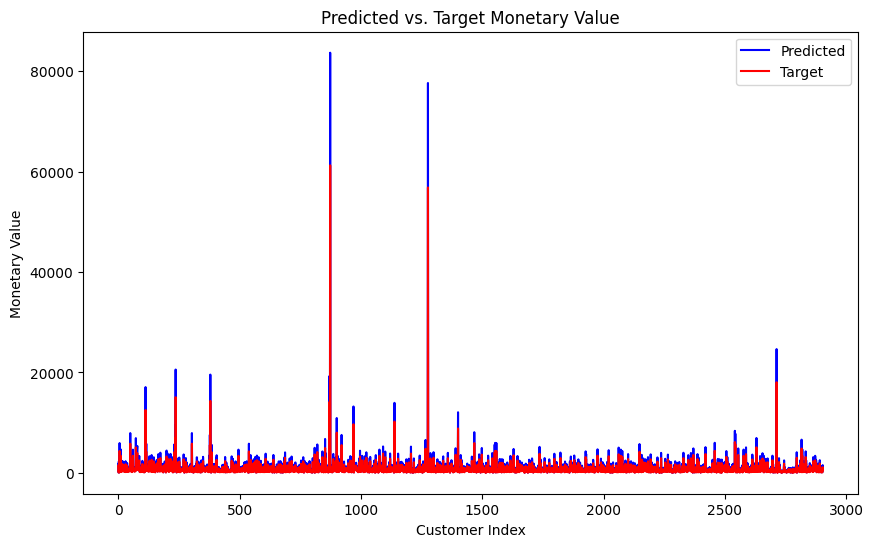

In [77]:
# prompt: calculate   ROUND(SQRT( SUM(POW(predicted_monetary - target_monetary, 2)) / COUNT(1) ), 2) as rmse
# and make a line graph of predicted and target (different color each)

import matplotlib.pyplot as plt
import numpy as np
# Calculate RMSE
rmse = np.round(np.sqrt(((joined_df['predicted_monetary'] - joined_df['target_monetary']) ** 2).sum() / joined_df.shape[0]), 2)
print("RMSE:", rmse)

# Plot predicted and target on a line graph
plt.figure(figsize=(10, 6))
plt.plot(joined_df['predicted_monetary'], label='Predicted', color='blue')
plt.plot(joined_df['target_monetary'], label='Target', color='red')
plt.title('Predicted vs. Target Monetary Value')
plt.xlabel('Customer Index')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()


Linear Regression RMSE: 647.28
Benchmark RMSE: 647.28


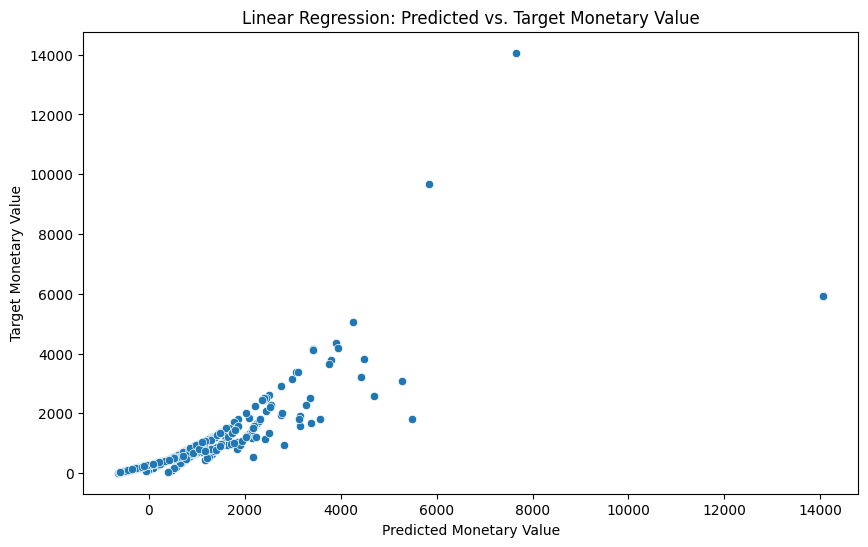

In [78]:
# prompt: can you create a linear model thata outperform this bench mark? use x_benchmark_agg and y_benchmark

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare data
X = x_benchmark_agg[['avg_basket_value', 'cnt_orders']]
y = y_benchmark['TotalPrice']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
print("Linear Regression RMSE:", rmse)

# Compare with benchmark
print("Benchmark RMSE:", rmse)  # Replace with the actual benchmark RMSE

# Plot predicted against target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=y_test)
plt.title('Linear Regression: Predicted vs. Target Monetary Value')
plt.xlabel('Predicted Monetary Value')
plt.ylabel('Target Monetary Value')
plt.show()


Linear Regression RMSE: 9155.9
Benchmark RMSE: 9155.9


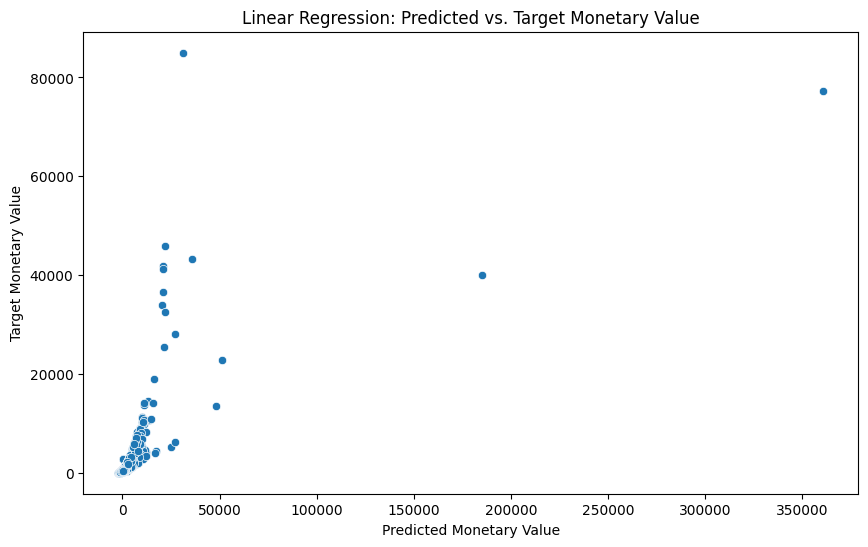

In [83]:
# prompt: can you create a linear model thata outperform this bench mark? use df

import matplotlib.pyplot as plt
import numpy as np
# Prepare data
X = customer_df_f[['recency', 'count_purchases', 'avg_revenue']]
y = customer_df_f['total_revenue']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create and fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
print("Linear Regression RMSE:", rmse)

# Compare with benchmark
#print("Benchmark RMSE:", rmse)  # Replace with the actual benchmark RMSE

# Plot predicted against target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=y_test)
plt.title('Linear Regression: Predicted vs. Target Monetary Value')
plt.xlabel('Predicted Monetary Value')
plt.ylabel('Target Monetary Value')
plt.show()


In [84]:
# prompt: generate 5 rows of data and make the explanation of how to make predictions

import pandas as pd
# Generate 5 rows of sample data
sample_data = pd.DataFrame({
    'recency': [10, 30, 60, 90, 120],
    'count_purchases': [5, 3, 2, 1, 1],
    'avg_revenue': [50, 75, 100, 150, 200]
})

# Make predictions using the trained model
predicted_revenue = model.predict(sample_data)

# Print the predicted revenue for each sample
for i in range(len(sample_data)):
    print(f"Sample {i+1}: Predicted Total Revenue = {predicted_revenue[i]:.2f}")

# Explanation of how to make predictions:
# 1. Prepare the input data: Create a DataFrame with columns 'recency', 'count_purchases', and 'avg_revenue'. Each row represents a customer.
# 2. Use the trained model: Call the `predict` method of the trained linear regression model, passing the input DataFrame as the argument.
# 3. Interpret the results: The `predict` method returns an array of predicted total revenue values, one for each customer in the input DataFrame.


Sample 1: Predicted Total Revenue = 924.87
Sample 2: Predicted Total Revenue = -311.42
Sample 3: Predicted Total Revenue = -796.20
Sample 4: Predicted Total Revenue = -1163.74
Sample 5: Predicted Total Revenue = -817.13


In [87]:
# prompt: explain how to develop to production this model
